In [38]:
import pandas as pd 
import numpy as np
from IPython.display import Audio
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import librosa
import librosa.display
%matplotlib inline

In [39]:
audio_file="/kaggle/input/urbansound8k/fold1/101415-3-0-2.wav"
y, sr = librosa.load(audio_file)
print("Playing the audio file:")
display(Audio(audio_file))

Playing the audio file:


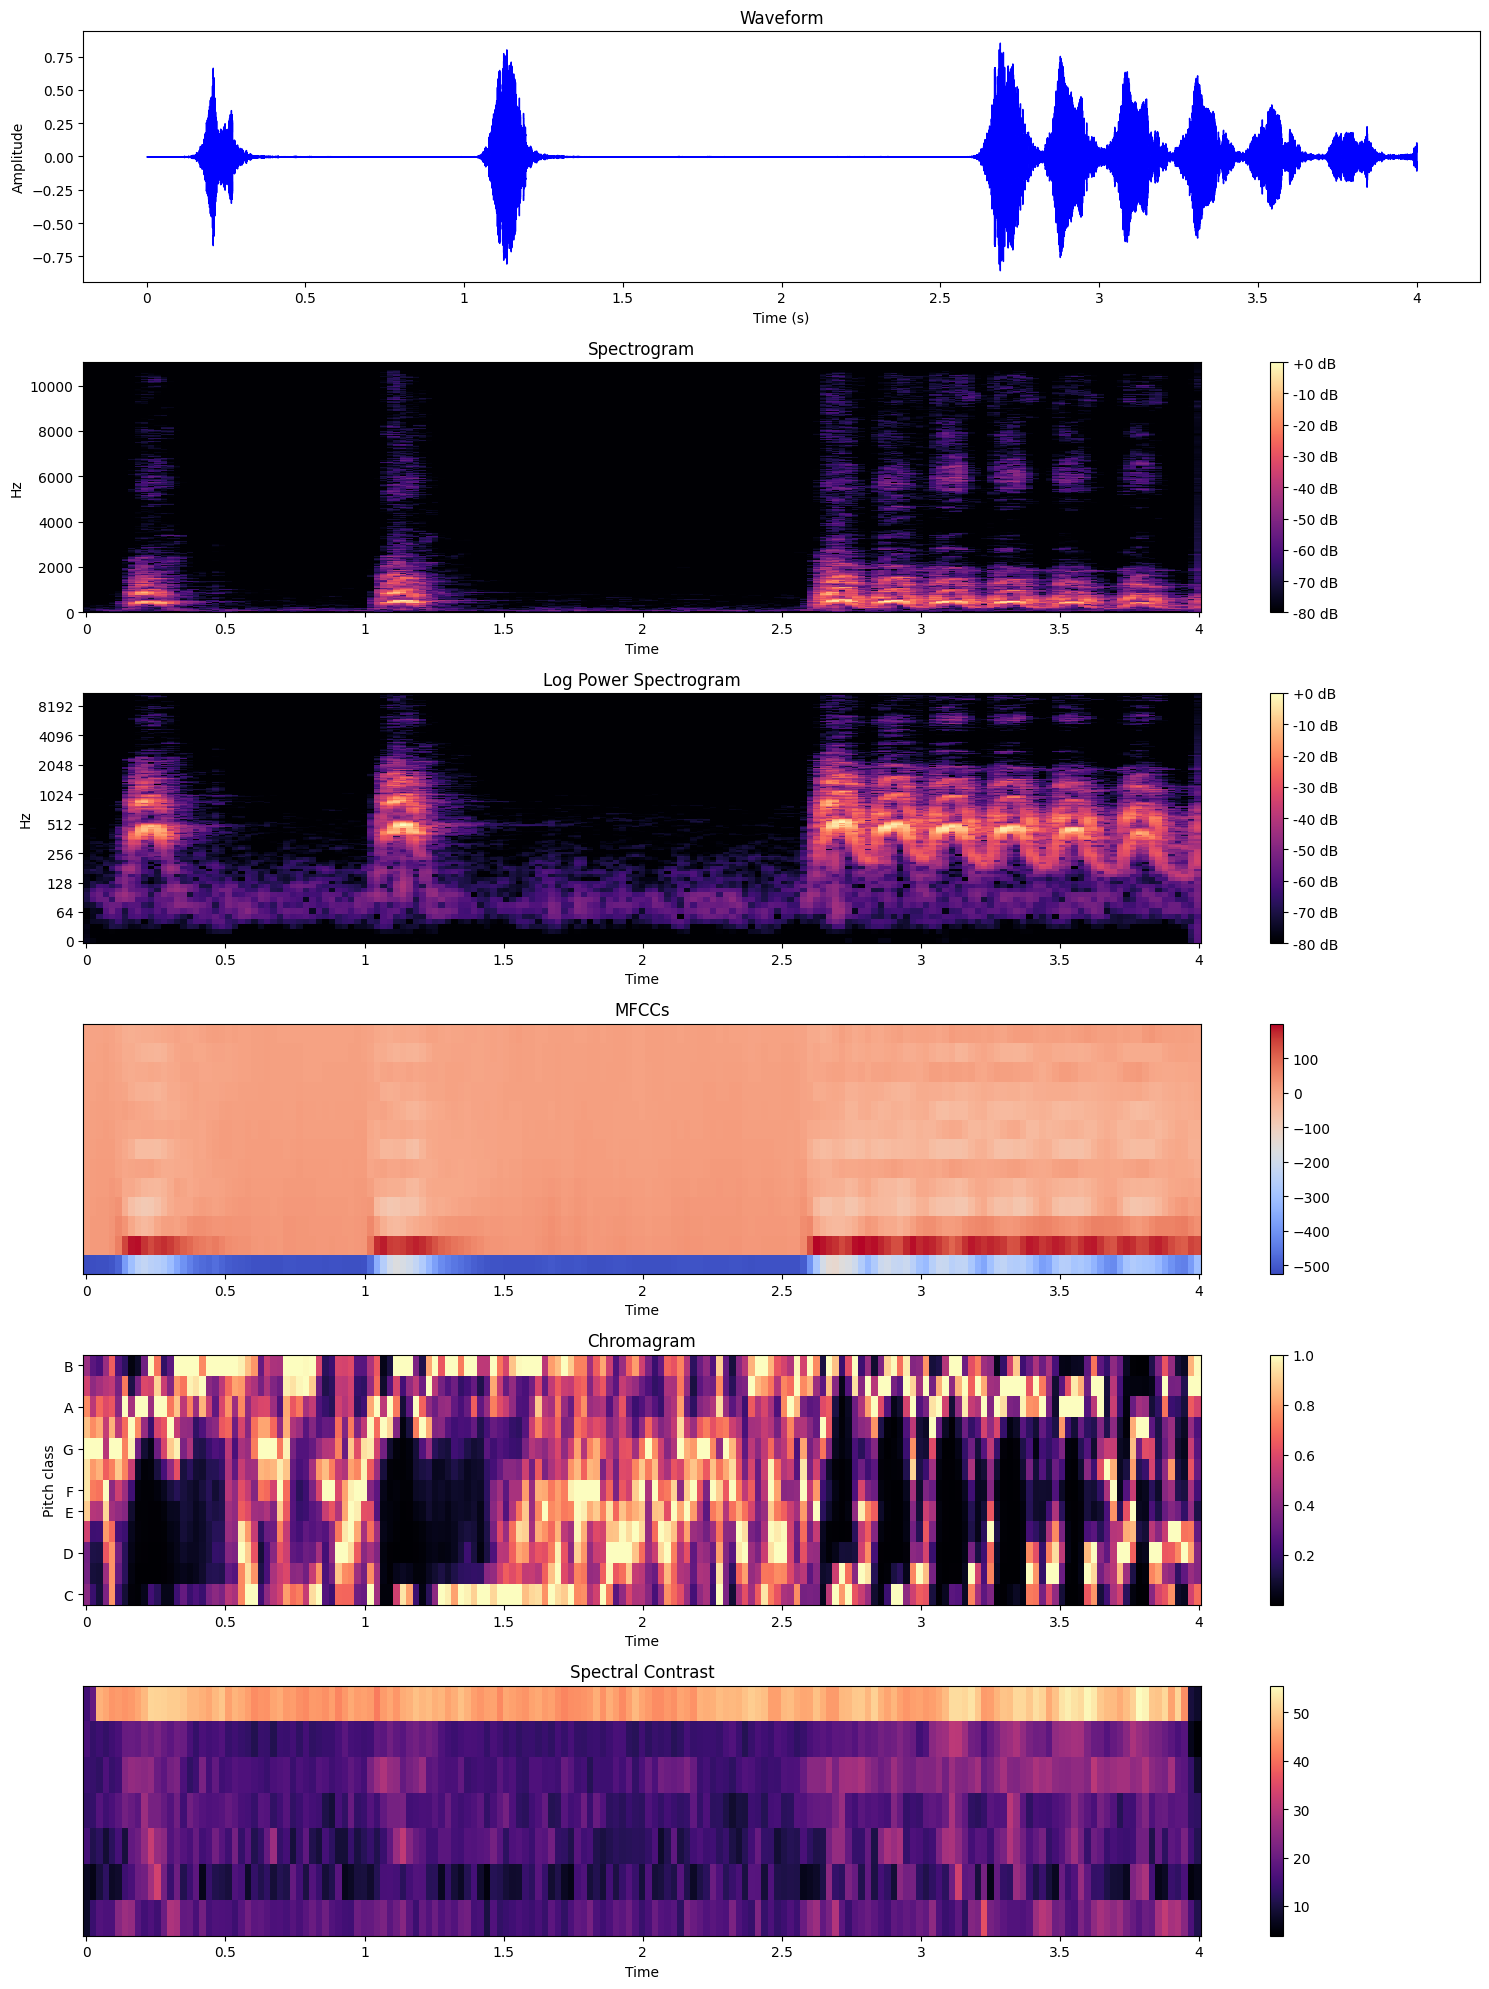

In [40]:
# Set up the figure for visualizations
plt.figure(figsize=(15, 20))

# 1. Waveform
plt.subplot(6, 1, 1)
librosa.display.waveshow(y, sr=sr, color='b')
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 2. Spectrogram
plt.subplot(6, 1, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

# 3. Log Power Spectrogram
plt.subplot(6, 1, 3)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Power Spectrogram')

# 4. MFCCs
plt.subplot(6, 1, 4)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCCs')

# 5. Chromagram
plt.subplot(6, 1, 5)
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')

# 6. Spectral Contrast
plt.subplot(6, 1, 6)
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
librosa.display.specshow(spectral_contrast, sr=sr, x_axis='time')
plt.colorbar()
plt.title('Spectral Contrast')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [41]:
print(f"Sample Rate: {sr} Hz")
print(f"Duration: {librosa.get_duration(y=y, sr=sr):.2f} seconds")
print(f"Number of Samples: {len(y)}")

Sample Rate: 22050 Hz
Duration: 4.00 seconds
Number of Samples: 88200


In [42]:
df=pd.read_csv("/kaggle/input/urbansound8k/UrbanSound8K.csv")

In [43]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [44]:
df['duration'] = df['end'] - df['start']

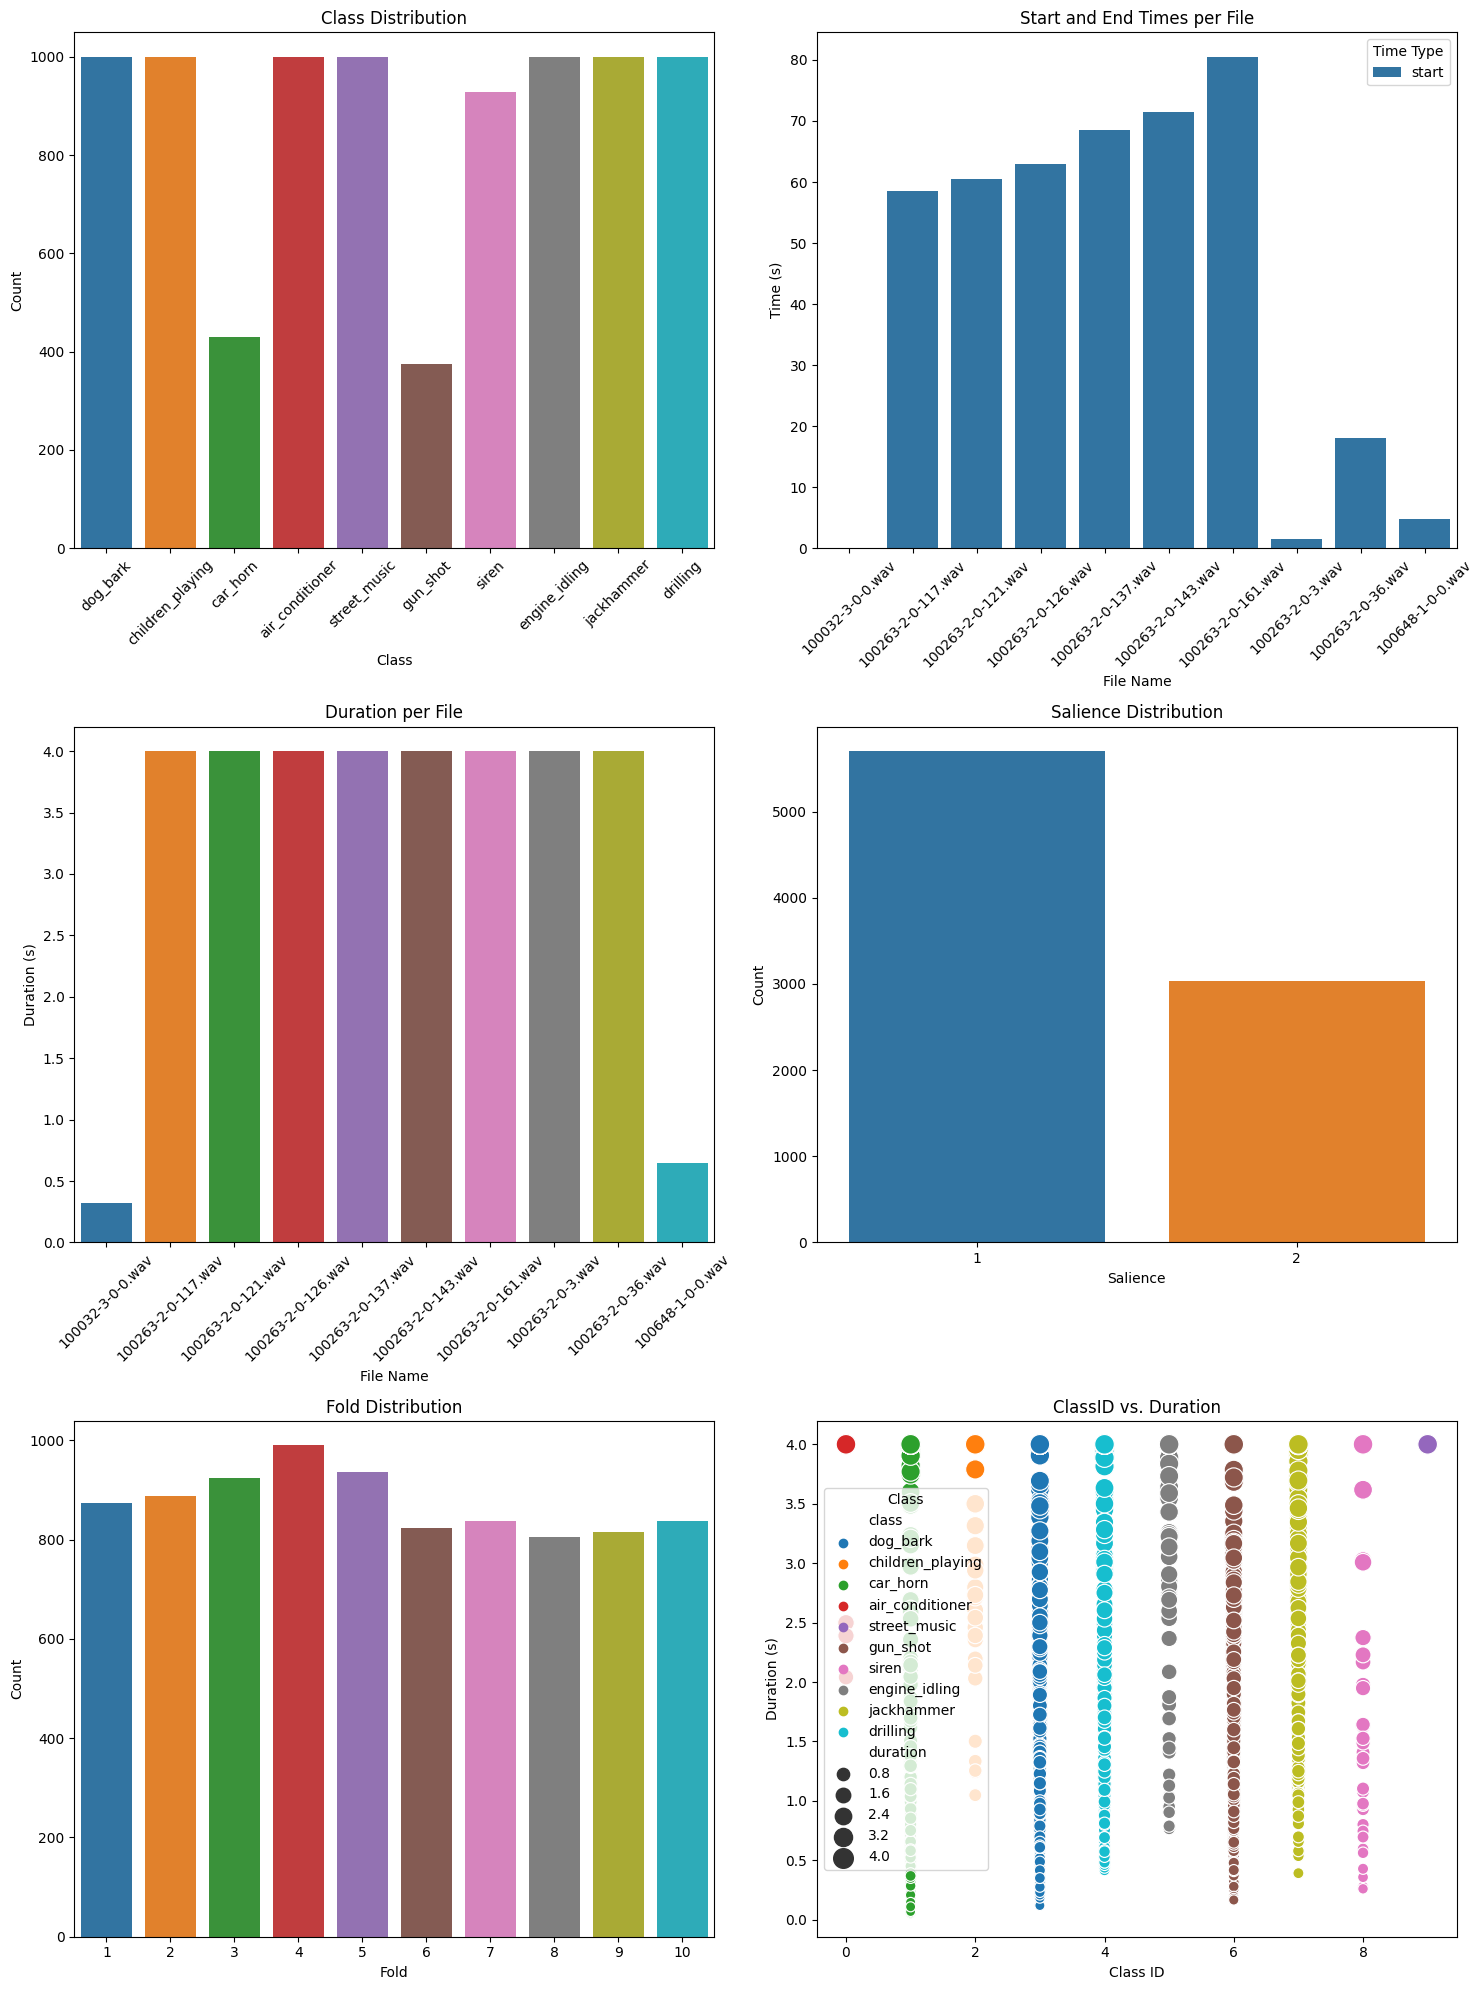

In [45]:
# Create a figure with multiple subplots
plt.figure(figsize=(15, 20))

# 1. Class Distribution
plt.subplot(3, 2, 1)
sns.countplot(data=df, x='class')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)

# 2. Start and End Times
plt.subplot(3, 2, 2)
df_melted = df.melt(id_vars=['slice_file_name'], value_vars=['start', 'end'], var_name='Time Type', value_name='Time (s)')
sns.barplot(data=df_melted[: 10], x='slice_file_name', y='Time (s)', hue='Time Type')
plt.title('Start and End Times per File')
plt.xlabel('File Name')
plt.ylabel('Time (s)')
plt.xticks(rotation=45)
plt.legend(title='Time Type')

# 3. Duration
plt.subplot(3, 2, 3)
sns.barplot(data=df[: 10], x='slice_file_name', y='duration')
plt.title('Duration per File')
plt.xlabel('File Name')
plt.ylabel('Duration (s)')
plt.xticks(rotation=45)

# 4. Salience Distribution
plt.subplot(3, 2, 4)
sns.countplot(data=df, x='salience')
plt.title('Salience Distribution')
plt.xlabel('Salience')
plt.ylabel('Count')

# 5. Fold Distribution
plt.subplot(3, 2, 5)
sns.countplot(data=df, x='fold')
plt.title('Fold Distribution')
plt.xlabel('Fold')
plt.ylabel('Count')

# 6. ClassID vs. Duration
plt.subplot(3, 2, 6)
sns.scatterplot(data=df, x='classID', y='duration', hue='class', size='duration', sizes=(50, 200))
plt.title('ClassID vs. Duration')
plt.xlabel('Class ID')
plt.ylabel('Duration (s)')
plt.legend(title='Class')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [46]:
df.drop(columns=["duration"],axis=1,inplace=True)

In [47]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [48]:
df.shape

(8732, 8)

In [49]:
df.isnull().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

In [50]:
frame_size=1024
hop_length=512

In [51]:
def mfcc_extractor(file_name):
    audio,sr=librosa.load(file_name)
    mfcc=librosa.feature.mfcc(y=audio,sr=sr,n_mfcc=10)
    mfcc_scaled=np.mean(mfcc.T,axis=0)
    return mfcc_scaled


def zcr_extractor(file_name):
    audio,sr=librosa.load(file_name)
    zcr=librosa.feature.zero_crossing_rate(audio,frame_length=frame_size,hop_length=hop_length)[0]
    zcr_scaled=np.mean(zcr.T,axis=0)
    return zcr_scaled

In [52]:
ind_features = []
audio_dataset_path = "/kaggle/input/urbansound8k/"


for index_num, row in tqdm(df.iterrows(), total=len(df)):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold' + str(row["fold"]),str(row["slice_file_name"]))
    label = row['class']
    
    mfcc_feat = mfcc_extractor(file_name)
    zcr_feat = zcr_extractor(file_name)
    
    ind_features.append([mfcc_feat, zcr_feat, label])

df= pd.DataFrame(ind_features, columns=['MFCCs', 'ZCR', 'Labels'])

 41%|████      | 3555/8732 [01:34<02:15, 38.12it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8325/8732 [03:37<00:08, 49.38it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [03:46<00:00, 38.51it/s]


In [53]:
df.head()

,MFCCs,ZCR,Labels
0,"[-211.93698, 62.581215, -122.81315, -60.745293...",0.127790,dog_bark
1,"[-417.00516, 99.336624, -42.995583, 51.073326,...",0.139174,children_playing
2,"[-452.39316, 112.36253, -37.578068, 43.195866,...",0.102104,children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",0.131091,children_playing
4,"[-439.63867, 103.86224, -42.658783, 50.690285,...",0.118249,children_playing


In [54]:
new_df=df.copy()
new_df.drop(columns=["ZCR"],axis=1,inplace=True)

In [55]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
X=np.array(new_df['MFCCs'].tolist())  ## independent features
y=np.array(new_df['Labels'].tolist())  ## dependent features
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Mapping of numeric labels to original categories
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label mapping (Category → Encoded Value):")
print(label_mapping)

Label mapping (Category → Encoded Value):
{'air_conditioner': 0, 'car_horn': 1, 'children_playing': 2, 'dog_bark': 3, 'drilling': 4, 'engine_idling': 5, 'gun_shot': 6, 'jackhammer': 7, 'siren': 8, 'street_music': 9}


In [56]:
reverse_mapping = dict(zip(range(len(le.classes_)), le.classes_))
print("\nReverse mapping (Encoded Value → Category):")
print(reverse_mapping)


Reverse mapping (Encoded Value → Category):
{0: 'air_conditioner', 1: 'car_horn', 2: 'children_playing', 3: 'dog_bark', 4: 'drilling', 5: 'engine_idling', 6: 'gun_shot', 7: 'jackhammer', 8: 'siren', 9: 'street_music'}


In [57]:
y_categorical = to_categorical(y_encoded)
y=y_categorical
print("Shape of one-hot labels:", y_categorical.shape)
print("First 5 one-hot labels:\n", y_categorical[:5])

Shape of one-hot labels: (8732, 10)
First 5 one-hot labels:
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6985, 10)
X_test shape: (1747, 10)
y_train shape: (6985, 10)
y_test shape: (1747, 10)


In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

num_labels = y.shape[1]
input_dim = X_train.shape[1]

model = Sequential()

model.add(Dense(256, input_shape=(input_dim,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,522 (1.16 MB)

 Trainable params: 302,218 (1.15 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [60]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True,verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # reduce LR by half
    patience=5,       # wait 5 epochs before reducing
    min_lr=1e-6,      # minimum learning rate
    verbose=1
)
history = model.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=100,batch_size=32,callbacks=[early_stop,reduce_lr],verbose=1)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.1878 - loss: 2.4802 - val_accuracy: 0.4471 - val_loss: 1.6196 - learning_rate: 0.0010
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3326 - loss: 1.8968 - val_accuracy: 0.4711 - val_loss: 1.5125 - learning_rate: 0.0010
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3767 - loss: 1.7845 - val_accuracy: 0.5129 - val_loss: 1.4220 - learning_rate: 0.0010
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4175 - loss: 1.6969 - val_accuracy: 0.5318 - val_loss: 1.4004 - learning_rate: 0.0010
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4255 - loss: 1.6412 - val_accuracy: 0.5363 - val_loss: 1.3404 - learning_rate: 0.0010
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4489 - loss: 1.6016 - val_accuracy: 0.5673 - val_loss: 1.2987 - learning_rate: 0.0010
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4620 - loss: 

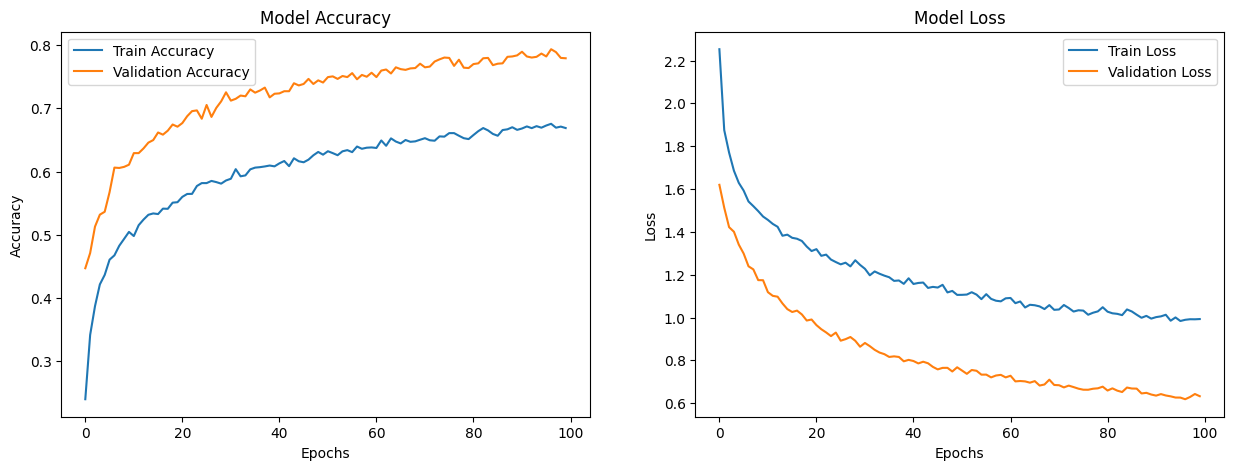

In [61]:
# Plot accuracy
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [62]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7831 - loss: 0.6531
Test Loss: 0.6185
Test Accuracy: 0.7934


In [63]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))


roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:

                  precision    recall  f1-score   support

 air_conditioner       0.82      0.95      0.88       200
        car_horn       0.82      0.59      0.69        86
children_playing       0.66      0.66      0.66       200
        dog_bark       0.82      0.70      0.76       200
        drilling       0.85      0.82      0.83       200
   engine_idling       0.87      0.94      0.90       200
        gun_shot       0.81      0.67      0.73        75
      jackhammer       0.81      0.93      0.86       200
           siren       0.86      0.92      0.89       186
    street_music       0.64      0.57      0.61       200

        accuracy                           0.79      1747
       macro avg       0.79      0.77      0.78      1747
    weighted avg       0.79      0.79      0.79      1747

ROC AUC Score: 0.9758


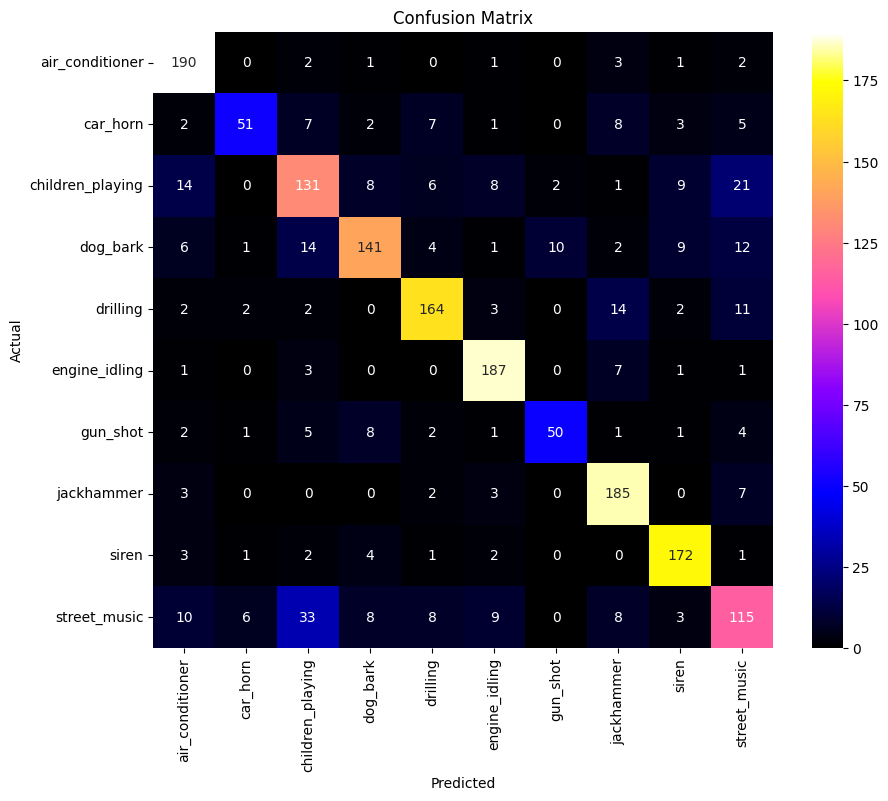

In [64]:

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='gnuplot2', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [65]:
def predict_custom_audio(file_name, model, le):
    mfcc_features = mfcc_extractor(file_name)
    # Reshape to (1, num_features) for prediction
    mfcc_features = mfcc_features.reshape(1, -1)
    # Predict probabilities
    pred_prob = model.predict(mfcc_features)
    # Convert to numeric label
    pred_label_index = np.argmax(pred_prob, axis=1)[0]
    # Convert numeric label to original category
    pred_label = le.inverse_transform([pred_label_index])[0]
    return pred_label, pred_prob

# Example usage
file_path = "/kaggle/input/urbansound8k/fold1/102842-3-1-5.wav"
pred_label, pred_prob = predict_custom_audio(file_path, model, le)
print(f"Predicted Class: {pred_label}")
print(f"Prediction Probabilities: {pred_prob}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Predicted Class: street_music
Prediction Probabilities: [[0.04710855 0.01973746 0.25412187 0.14491054 0.01893075 0.02444447
  0.07761153 0.03854893 0.00920355 0.36538237]]


In [66]:
display(Audio(file_path))

In [67]:
zcr_df=df.copy()
zcr_df.drop(columns=["MFCCs"],axis=1,inplace=True)

In [68]:
zcr_df.head()

,ZCR,Labels
0,0.127790,dog_bark
1,0.139174,children_playing
2,0.102104,children_playing
3,0.131091,children_playing
4,0.118249,children_playing


In [69]:

X=np.array(zcr_df['ZCR'].tolist()).reshape(-1,1)  ## independent features
y=np.array(zcr_df['Labels'].tolist())  ## dependent features
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Mapping of numeric labels to original categories
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label mapping (Category → Encoded Value):")
print(label_mapping)

Label mapping (Category → Encoded Value):
{'air_conditioner': 0, 'car_horn': 1, 'children_playing': 2, 'dog_bark': 3, 'drilling': 4, 'engine_idling': 5, 'gun_shot': 6, 'jackhammer': 7, 'siren': 8, 'street_music': 9}


In [70]:
y_categorical = to_categorical(y_encoded)
y=y_categorical
print("Shape of one-hot labels:", y_categorical.shape)
print("First 5 one-hot labels:\n", y_categorical[:5])

Shape of one-hot labels: (8732, 10)
First 5 one-hot labels:
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
num_labels = y_categorical.shape[1]

X_train shape: (6985, 1)
X_test shape: (1747, 1)
y_train shape: (6985, 10)
y_test shape: (1747, 10)


In [72]:
model2 = Sequential()

model2.add(Dense(256, input_shape=(1,)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))

model2.add(Dense(512))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))

model2.add(Dense(256))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))

model2.add(Dense(128))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))

model2.add(Dense(num_labels, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302,218 (1.15 MB)

 Trainable params: 299,914 (1.14 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [73]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True,verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # reduce LR by half
    patience=5,       # wait 5 epochs before reducing
    min_lr=1e-6,      # minimum learning rate
    verbose=1
)
history2 = model2.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=100,batch_size=32,callbacks=[early_stop,reduce_lr],verbose=1)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.1579 - loss: 2.5733 - val_accuracy: 0.1070 - val_loss: 2.3079 - learning_rate: 0.0010
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2011 - loss: 2.1823 - val_accuracy: 0.1219 - val_loss: 2.2613 - learning_rate: 0.0010
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2139 - loss: 2.1128 - val_accuracy: 0.1866 - val_loss: 2.0973 - learning_rate: 0.0010
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2288 - loss: 2.1015 - val_accuracy: 0.2570 - val_loss: 2.0228 - learning_rate: 0.0010
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2191 - loss: 2.0783 - val_accuracy: 0.2461 - val_loss: 2.0161 - learning_rate: 0.0010
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2284 - loss: 2.0632 - val_accuracy: 0.2570 - val_loss: 2.0082 - learning_rate: 0.0010
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2251 - loss: 

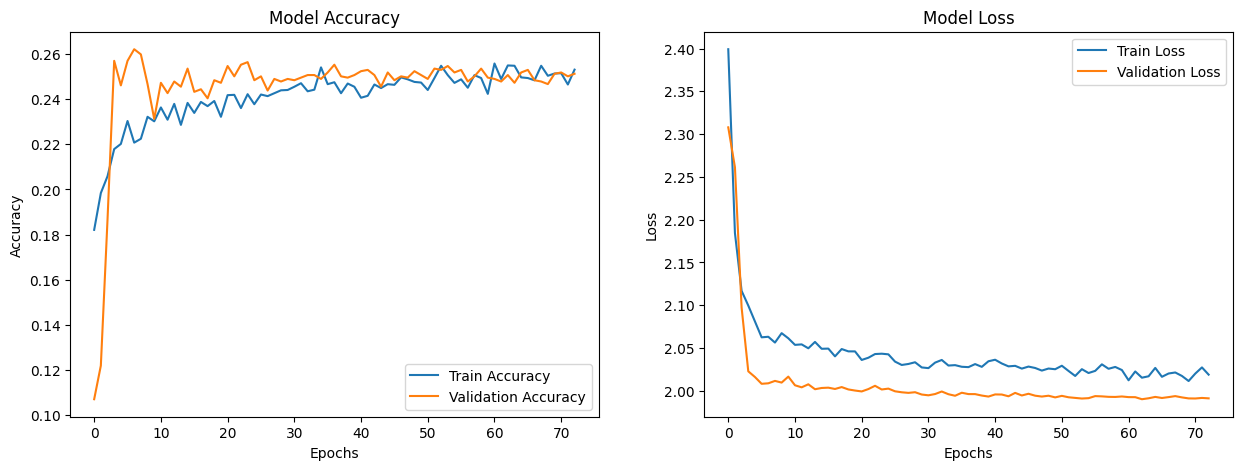

In [74]:
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [75]:
loss, accuracy = model2.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2452 - loss: 1.9990
Test Loss: 1.9902
Test Accuracy: 0.2507


In [76]:
# Predict probabilities
y_pred_prob = model2.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))


# Multi-class ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report:

                  precision    recall  f1-score   support

 air_conditioner       0.00      0.00      0.00       200
        car_horn       0.00      0.00      0.00        86
children_playing       0.23      0.15      0.18       200
        dog_bark       0.00      0.00      0.00       200
        drilling       0.37      0.64      0.47       200
   engine_idling       0.33      0.37      0.35       200
        gun_shot       0.00      0.00      0.00        75
      jackhammer       0.00      0.00      0.00       200
           siren       0.23      0.57      0.33       186
    street_music       0.17      0.51      0.26       200

        accuracy                           0.25      1747
       macro avg       0.13      0.22      0.16      1747
    weighted avg       0.15      0.25      0.18      1747

ROC AUC Score: 0.7071


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


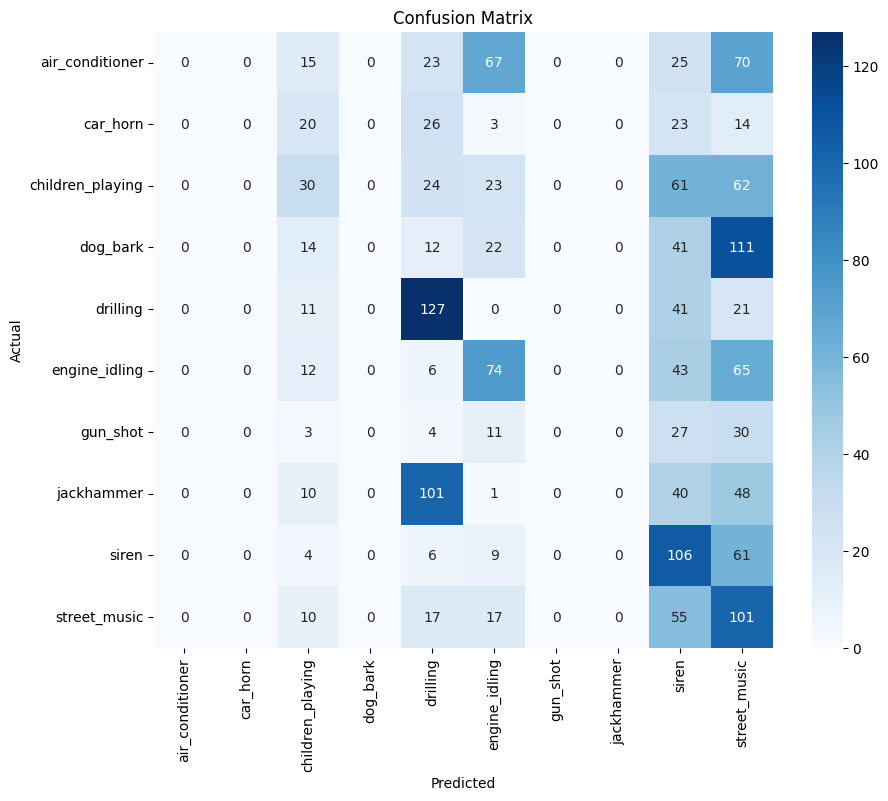

In [77]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()